## Importing libraries and dataset

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import tensorflow as tf

Reading the dataset

In [2]:
breast_cancer_df=pd.read_csv("cancer_detection.csv")
breast_cancer_df=breast_cancer_df.drop(labels={
    "Unnamed: 32",
    "id"},axis=1)
print(breast_cancer_df.head())

  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33 

## Performing EDA on the dataset

Converting the categorical columns to numeric columns 

In [3]:
le=LabelEncoder()
breast_cancer_df["diagnosis"]=le.fit_transform(breast_cancer_df["diagnosis"])
print(breast_cancer_df.head())
print(breast_cancer_df["diagnosis"].value_counts())

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

We would first want to have a look at how the diagnosis is distributed, i.e. what proportion of the tumors were diagnosed as malignant or benign.

In [ ]:
sns.barplot(x=breast_cancer_df["diagnosis"].value_counts().index,y=breast_cancer_df["diagnosis"].value_counts(),hue=breast_cancer_df["diagnosis"].value_counts().index)
plt.xlabel("Type of tumor")

Identify the correlations

In [ ]:
# print(breast_cancer_df.columns)
correlation_matrix=breast_cancer_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix,annot=True)
correlation_coefficient=correlation_matrix.loc["diagnosis"]
print(correlation_coefficient.dtype)
# print(temp_correlation_coefficient[1])
# print(correlation_coefficient[correlation_coefficient>=0.5])

Since there are numerous features which influence the decision about whether a tumour is malignant or benign, we will use only those features which are relevant and have high correlation with the diagnosis. Thus here we try to extract the top 15 features having the highest correlation and these features would then be used to design our model.

In [6]:
new_correlation_coefficient=abs(correlation_coefficient)
temp_correlation_coefficient=new_correlation_coefficient.sort_values(ascending=False)
top=temp_correlation_coefficient[1:16]
bottom=temp_correlation_coefficient[16:]
# print(top)
print("\n")
top_correlation_coefficient=correlation_coefficient[top.index]
print(top_correlation_coefficient)



concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
compactness_mean        0.596534
compactness_worst       0.590998
radius_se               0.567134
perimeter_se            0.556141
area_se                 0.548236
Name: diagnosis, dtype: float64


In [7]:
new_breast_cancer_df=breast_cancer_df.drop(labels=bottom.index,axis=1)
print(new_breast_cancer_df.head())

   diagnosis  radius_mean  perimeter_mean  area_mean  compactness_mean  \
0          1        17.99          122.80     1001.0           0.27760   
1          1        20.57          132.90     1326.0           0.07864   
2          1        19.69          130.00     1203.0           0.15990   
3          1        11.42           77.58      386.1           0.28390   
4          1        20.29          135.10     1297.0           0.13280   

   concavity_mean  concave points_mean  radius_se  perimeter_se  area_se  \
0          0.3001              0.14710     1.0950         8.589   153.40   
1          0.0869              0.07017     0.5435         3.398    74.08   
2          0.1974              0.12790     0.7456         4.585    94.03   
3          0.2414              0.10520     0.4956         3.445    27.23   
4          0.1980              0.10430     0.7572         5.438    94.44   

   radius_worst  perimeter_worst  area_worst  compactness_worst  \
0         25.38           184.6

We would now try to visualize the correlations of the features by using a bar chart.

In [ ]:
sns.barplot(x=top_correlation_coefficient.index,y=top_correlation_coefficient)
plt.xticks(rotation=75)
plt.xlabel("Features")

We can also get an idea about how the values of the features themselves are distributed using a histogram for each of these features. 

In [ ]:
for col in new_breast_cancer_df.columns:
    plt.figure()
    sns.histplot(new_breast_cancer_df[col],kde=True)

## Data Preprocessing

It can be clearly observed from the above histograms that the features are unequally distributed i.e. their ranges are not the same. This leads to issues in the modelling process where incorrect weights can be attached to the features. Thus we would like to scale the inputs to have the same range of values. 

In [10]:
scaler=StandardScaler()
diagnosis_df=new_breast_cancer_df["diagnosis"]
scaled_breast_cancer_array=scaler.fit_transform(new_breast_cancer_df[top.index])
print(scaled_breast_cancer_array.shape)
scaled_breast_cancer_inputs=pd.DataFrame(scaled_breast_cancer_array,columns=top.index)
scaled_breast_cancer_df=scaled_breast_cancer_inputs.join(diagnosis_df)
print(scaled_breast_cancer_df.head(),"\n",scaled_breast_cancer_df["diagnosis"].value_counts())
for col in scaled_breast_cancer_df.columns:
    print(scaled_breast_cancer_df[col].describe())

(569, 15)
   concave points_worst  perimeter_worst  concave points_mean  radius_worst  \
0              2.296076         2.303601             2.532475      1.886690   
1              1.087084         1.535126             0.548144      1.805927   
2              1.955000         1.347475             2.037231      1.511870   
3              2.175786        -0.249939             1.451707     -0.281464   
4              0.729259         1.338539             1.428493      1.298575   

   perimeter_mean  area_worst  radius_mean  area_mean  concavity_mean  \
0        1.269934    2.001237     1.097064   0.984375        2.652874   
1        1.685955    1.890489     1.829821   1.908708       -0.023846   
2        1.566503    1.456285     1.579888   1.558884        1.363478   
3       -0.592687   -0.550021    -0.768909  -0.764464        1.915897   
4        1.776573    1.220724     1.750297   1.826229        1.371011   

   concavity_worst  compactness_mean  compactness_worst  radius_se  \
0     

Splitting the dataset into training and testing sets. The model is trained using only the training set while the test set is then used to check whether the model performs similarly when confronted with previously unknown data. 

In [11]:
breast_cancer_train,breast_cancer_test=train_test_split(scaled_breast_cancer_df,test_size=0.2,random_state=42,shuffle=True,stratify=scaled_breast_cancer_df["diagnosis"])

We have diagnosis as a categorical column in this dataset which also happens to be our target variable. Thus we would like this variable to be distributed in equal proportion in both the testing and training sets. As a result, we have stratified the diagnosis column. This is important as we do not want higher values of 0 in one set and higher values of 1 in the other. 

In [14]:
breast_cancer_train.diagnosis.value_counts()
print(breast_cancer_train.shape)

(455, 16)


In [13]:
breast_cancer_test.diagnosis.value_counts()

diagnosis
0    72
1    42
Name: count, dtype: int64

## Model Selection

Now we would try to analyze the results obtained by using various classification models and noting down the evaluation metrics. Various models such as Logistic Regression, Decision Tree, Random Forest, Naive Bayes, KNN,etc. will be used for the comparison. Metrics such as confusion matrix, accuracy score and classification report would be used. We would also have a look at the weights assigned to each of the features by these models and compare them with the coefficients obtained during the data analysis.

### Classification Models

In [28]:
def model_evaluation_train(model):
    train_inputs=breast_cancer_train[top.index]
    train_targets=breast_cancer_train["diagnosis"]
    model.fit(train_inputs,train_targets)
    train_predictions=model.predict(train_inputs)
    print(classification_report(train_targets,train_predictions))
    print(confusion_matrix(train_targets,train_predictions))
    train_accuracy=accuracy_score(train_targets,train_predictions)
    print(train_accuracy)

    test_inputs=breast_cancer_test[top.index]
    test_targets=breast_cancer_test["diagnosis"]
    test_predictions=model.predict(test_inputs)
    print(classification_report(test_targets,test_predictions))
    print(confusion_matrix(test_targets,test_predictions))
    test_accuracy=accuracy_score(test_targets,test_predictions)
    print(test_accuracy)

    return train_accuracy,test_accuracy

    # weights=model.coef_
    # print(weights)
    # sns.barplot(x=top.index,y=weights.flatten())
    # plt.xticks(rotation=75)

Logistic Regression

In [29]:
logistic_train_accuracy,logistic_test_accuracy=model_evaluation_train(LogisticRegression())

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       285
           1       0.96      0.92      0.94       170

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.95       455
weighted avg       0.96      0.96      0.96       455

[[279   6]
 [ 14 156]]
0.9560439560439561
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

[[72  0]
 [ 3 39]]
0.9736842105263158


Decision Tree

In [30]:
dt_train_accuracy,dt_test_accuracy=model_evaluation_train(DecisionTreeClassifier())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

[[285   0]
 [  0 170]]
1.0
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        72
           1       0.90      0.88      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

[[68  4]
 [ 5 37]]
0.9210526315789473


Random Forest

In [31]:
rf_train_accuracy,rf_test_accuracy=model_evaluation_train(RandomForestClassifier())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

[[285   0]
 [  0 170]]
1.0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

[[72  0]
 [ 5 37]]
0.956140350877193


KNN

In [32]:
knn_train_accuarcy,knn_test_accuracy=model_evaluation_train(KNeighborsClassifier())

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       285
           1       0.96      0.90      0.93       170

    accuracy                           0.95       455
   macro avg       0.95      0.94      0.94       455
weighted avg       0.95      0.95      0.95       455

[[278   7]
 [ 17 153]]
0.9472527472527472
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

[[71  1]
 [ 6 36]]
0.9385964912280702


KNN with custom number of neighbours

In [33]:
modifiedknn_train_accuracy,modifiedknn_test_accuracy=model_evaluation_train(KNeighborsClassifier(n_neighbors=3))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       285
           1       0.96      0.94      0.95       170

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

[[279   6]
 [ 10 160]]
0.9648351648351648
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        72
           1       0.93      0.90      0.92        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

[[69  3]
 [ 4 38]]
0.9385964912280702


Naive Bayes

In [34]:
bayes_train_accuracy,bayes_test_accuracy=model_evaluation_train(GaussianNB())

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       285
           1       0.92      0.88      0.90       170

    accuracy                           0.93       455
   macro avg       0.93      0.92      0.92       455
weighted avg       0.93      0.93      0.93       455

[[272  13]
 [ 20 150]]
0.9274725274725275
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

[[71  1]
 [ 6 36]]
0.9385964912280702


Simple Gradient Descent

In [35]:
sgd_train_accuracy,sgd_test_accuracy=model_evaluation_train(SGDClassifier())

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       285
           1       0.93      0.94      0.94       170

    accuracy                           0.95       455
   macro avg       0.95      0.95      0.95       455
weighted avg       0.95      0.95      0.95       455

[[273  12]
 [ 10 160]]
0.9516483516483516
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

[[70  2]
 [ 3 39]]
0.956140350877193


SVC

In [36]:
svc_train_accuracy,svc_test_accuracy=model_evaluation_train(SVC())

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       285
           1       0.97      0.91      0.94       170

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.95       455
weighted avg       0.96      0.96      0.96       455

[[281   4]
 [ 16 154]]
0.9560439560439561
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

[[72  0]
 [ 5 37]]
0.956140350877193


XGBoost

In [37]:
xg_train_accuracy,xg_test_accuracy=model_evaluation_train(XGBClassifier())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

[[285   0]
 [  0 170]]
1.0
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

[[72  0]
 [ 3 39]]
0.9736842105263158


Gradient Boosting

In [38]:
gb_train_accuracy,gb_test_accuracy=model_evaluation_train(GradientBoostingClassifier())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

[[285   0]
 [  0 170]]
1.0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

[[72  0]
 [ 5 37]]
0.956140350877193


### Neural Network

In [15]:
import keras
model=keras.Sequential([
    keras.layers.Dense(16,activation="relu",input_shape=(15,)),
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid")
])

c:\Users\Areeb\Desktop\VS CODE Workspace\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [25]:
model.fit(breast_cancer_train[top.index],breast_cancer_train["diagnosis"],epochs=100)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - loss: 0.1320 
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9458 - loss: 0.1276 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9593 - loss: 0.1049
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.0941
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9648 - loss: 0.1021
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9657 - loss: 0.1092
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9605 - loss: 0.0902  
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9510 - loss: 0.1186
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9547 - loss: 0.1105 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9522 - loss: 0.1403
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9648 - loss: 0.0909
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accu

In [26]:
loss,accuracy=model.evaluate(breast_cancer_test[top.index],breast_cancer_test["diagnosis"])
print(f"the accuracy is {accuracy*100}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9701 - loss: 0.0600
the accuracy is 98.24561476707458


## Visualizing the results and comparing the models

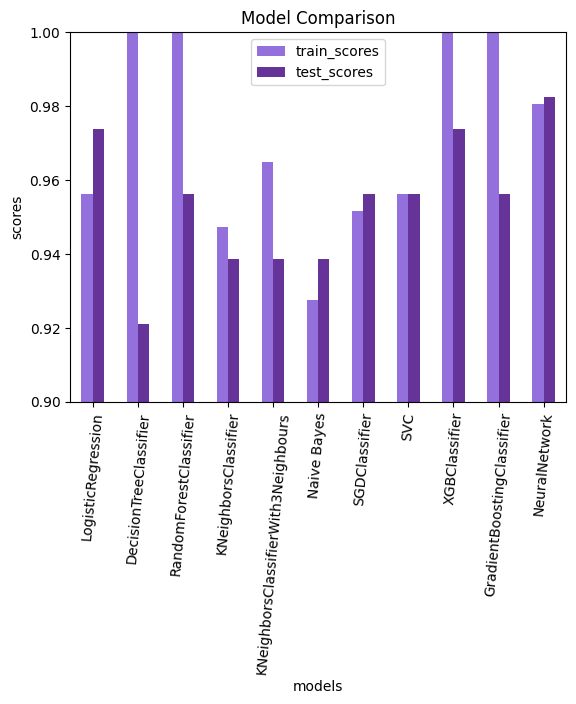

In [39]:
results_array=np.array([["LogisticRegression",logistic_train_accuracy,logistic_test_accuracy],["DecisionTreeClassifier",dt_train_accuracy,dt_test_accuracy],["RandomForestClassifier",rf_train_accuracy,rf_test_accuracy],["KNeighborsClassifier",knn_train_accuarcy,knn_test_accuracy],["KNeighborsClassifierWith3Neighbours",modifiedknn_train_accuracy,modifiedknn_test_accuracy],["Naive Bayes",bayes_train_accuracy,bayes_test_accuracy],["SGDClassifier",sgd_train_accuracy,sgd_test_accuracy],["SVC",svc_train_accuracy,svc_test_accuracy],["XGBClassifier",xg_train_accuracy,xg_test_accuracy],["GradientBoostingClassifier",gb_train_accuracy,gb_test_accuracy],["NeuralNetwork",0.9805,accuracy]])
# print(results_array.shape)

results_df=pd.DataFrame(data=results_array,columns=["models","train_scores","test_scores"])
# print(results_df.head())
results_df["train_scores"]=pd.to_numeric(results_df["train_scores"])
results_df["test_scores"]=pd.to_numeric(results_df["test_scores"])
# print(results_df.head(),"\n",results_df["train_scores"].dtype,results_df["test_scores"].dtype)

results_df.plot(kind="bar",xlabel="models",ylabel="scores",x="models",color=["mediumpurple","rebeccapurple"],title="Model Comparison")
plt.xticks(rotation=85)
plt.ylim([0.9,1.0])
plt.show()

## Conclusion

From the model comparison bar chart we can observe that: 
1. Some models like DecisionTree, RandomForest, XGBoost and Gradient Boosting have overfitted the data as they give 100% accuracy. However this shortfall is clearly visible whne compared with the accuracy obtained on the test data, which are lower compared to 100%. 
2. The SVC model shows similar accuracy for both training and testing data and also has a higher accuracy of almost 96%. This indicates that the SVC model could be a suitable choice for the breast cancer detection.
3. The k-nearest neighbours model was used with two different parameters: the default model where the number of neighbours is 5 and a modified version where we took the number of neighbours as 3. We can observe that the modified model gives a higher accuracy score than the default, although the deviation from the accuracy on the test data is higher for the modified model. 
4. We have also used a nueral network for prediction of breast cancer. This network consists of 3 layers, an input layer,a hidden layer and an output layer. The input and hidden layer implement the relu activation function while the output layer implements the sigmoid activation function as we are performing binary classification. This model was run through 100 epochs and gives us the highest accuracy of about 98% which remains almost the same on the test data as well. Thus the neural networks with 100 epochs turn out to be the best model for breast cancer detection.